# Library

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import koreanize_matplotlib


# Baseline 모델 비교


🔍 Model: XGBoost

🔍 Model: RandomForest

🔍 Model: LightGBM
[LightGBM] [Info] Number of positive: 2456, number of negative: 4029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3678
[LightGBM] [Info] Number of data points in the train set: 6485, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378720 -> initscore=-0.494984
[LightGBM] [Info] Start training from score -0.494984
[LightGBM] [Info] Number of positive: 2302, number of negative: 4147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3709
[LightGBM] [Info] Number of data points in the train set: 6449, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356955 -> initscore=-0.588607
[LightGBM] [

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📊 Cross-Validation & Test MCI F1:
model  LightGBM  LinearSVM  LogisticRegression  RandomForest  XGBoost
fold                                                                 
1         0.277      0.251               0.266         0.210    0.318
2         0.270      0.100               0.114         0.211    0.268
3         0.316      0.184               0.202         0.252    0.311
Test      0.382      0.149               0.170         0.332    0.429


/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_24049/3132581330.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_feats, palette="viridis")


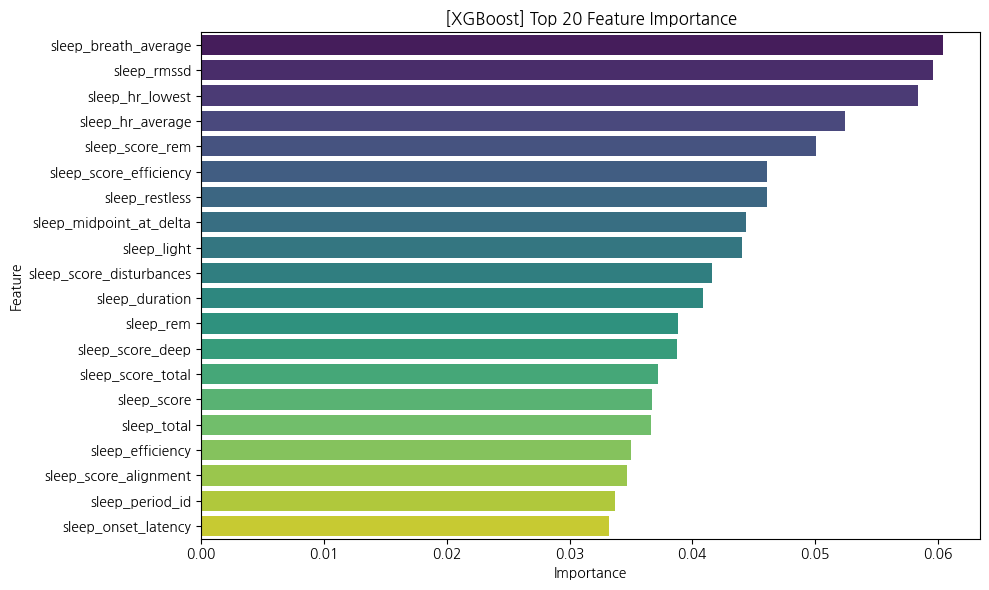

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_24049/3132581330.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_feats, palette="viridis")


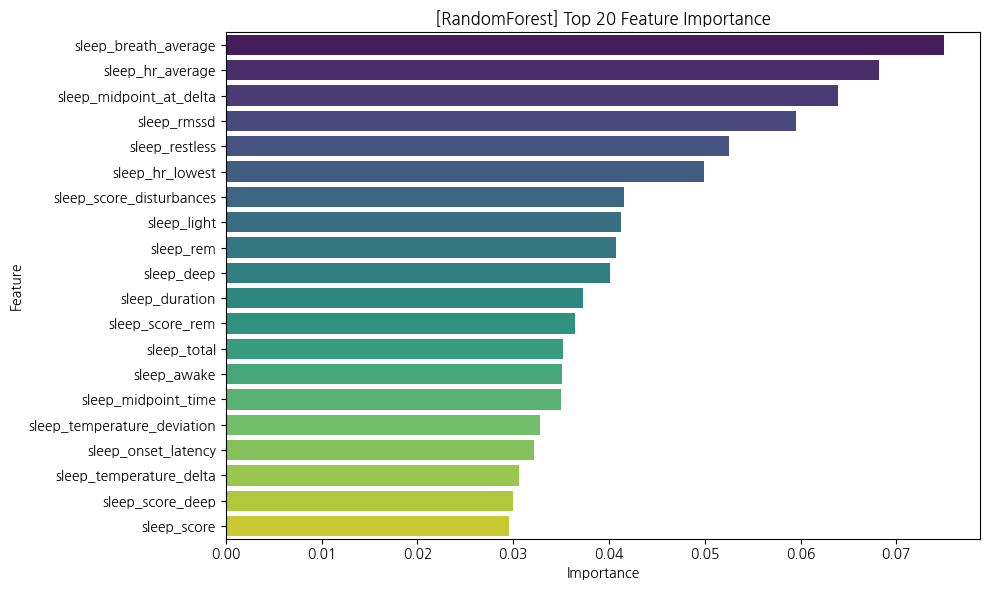

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_24049/3132581330.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_feats, palette="viridis")


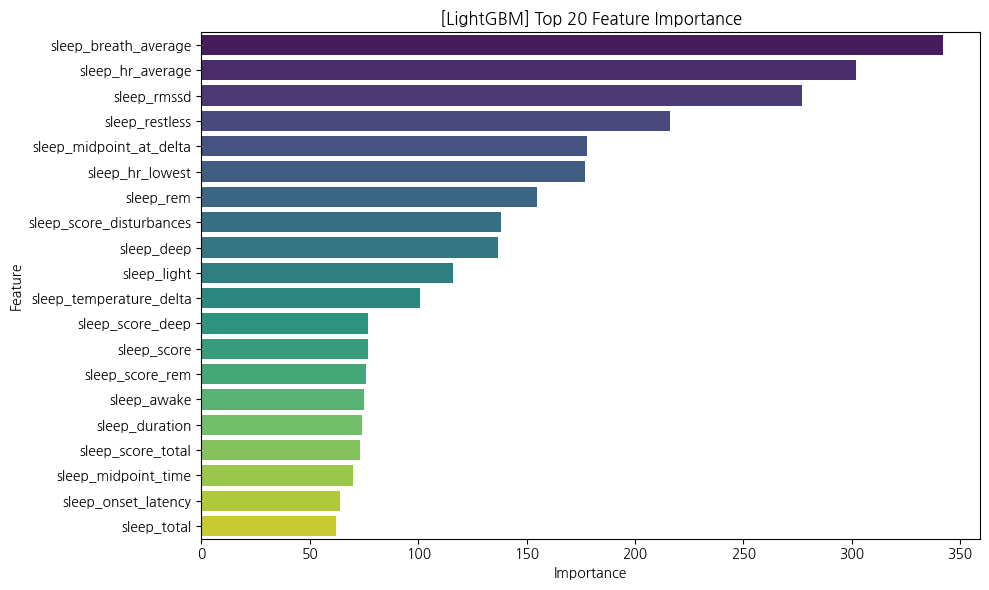

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_24049/3132581330.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_feats, palette="viridis")


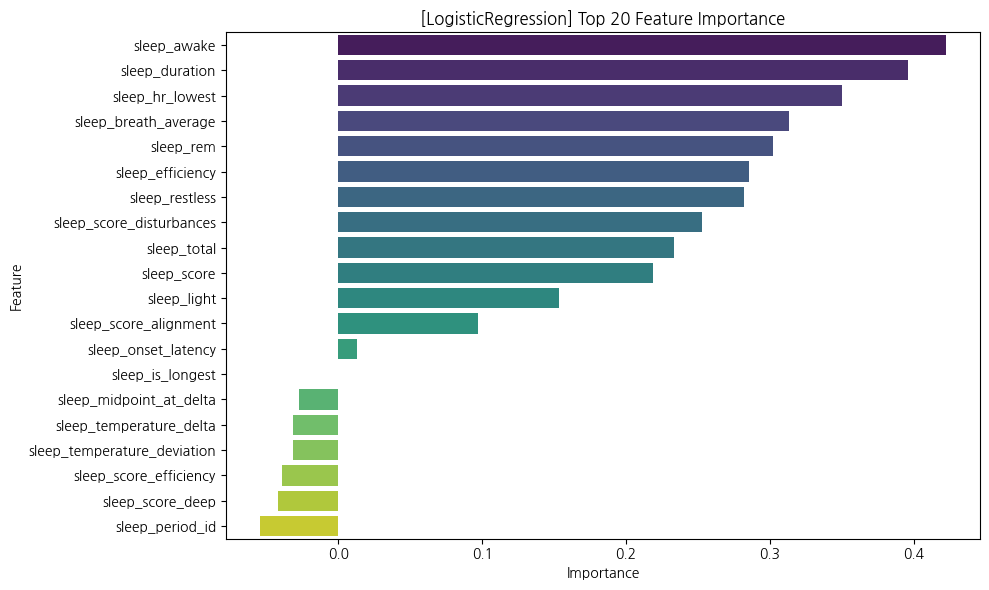

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_24049/3132581330.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_feats, palette="viridis")


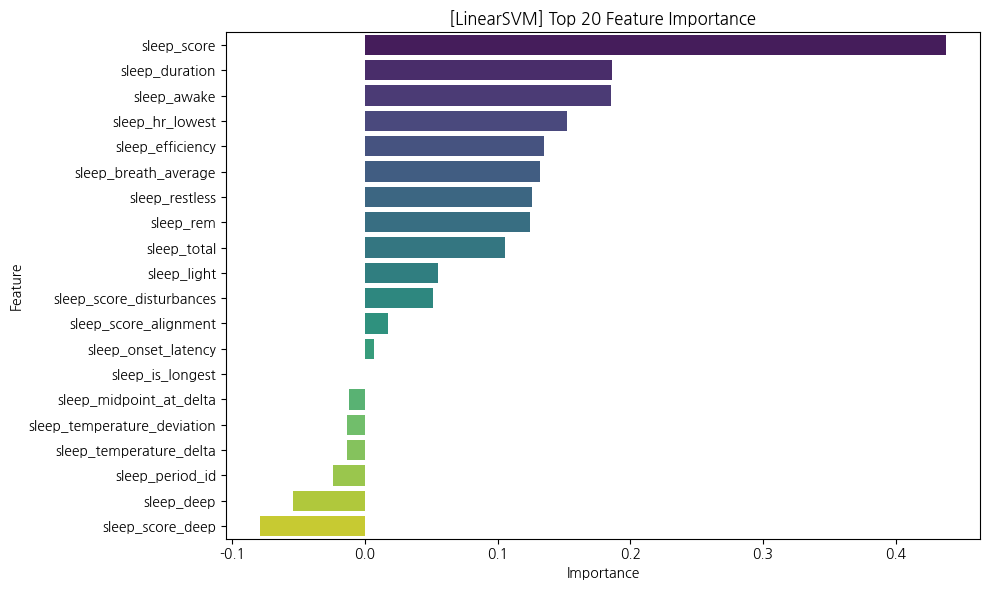

In [2]:
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 1})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/base/train_label.csv"
train_sleep = "./data/base/train_sleep.csv"
test_label = "./data/base/validation_label.csv"
test_sleep = "./data/base/validation_sleep.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_sleep)
test_df = load_sleep_data(test_label, test_sleep)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
substrings_to_remove = ['Unnamed: 0']
numeric_cols = [col for col in numeric_cols if not any(col in sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values
y = train_df["label"].values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["label"].values

# -------------------------
# 1. 모델 정의
# -------------------------
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "LinearSVM": LinearSVC(random_state=42, max_iter=10000)
}

# -------------------------
# 2. 결과 저장 및 CV 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
results = []
feature_importance_all = {}

for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    total_cm = np.zeros((2, 2), dtype=int)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y, groups)):
        X_train_fold, y_train_fold = X_scaled[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X_scaled[val_idx], y[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
        total_cm += cm

        report = classification_report(y_val_fold, y_pred, output_dict=True)
        fold_metrics.append({
            "model": name,
            "fold": fold + 1,
            "mci_recall": report["1"]["recall"],
            "mci_f1": report["1"]["f1-score"]
        })

    # ✅ 전체 데이터로 학습 + 테스트 평가
    model.fit(X_scaled, y)
    y_pred_test = model.predict(X_test_scaled)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)
    fold_metrics.append({
        "model": name,
        "fold": "Test",
        "mci_recall": test_report["1"]["recall"],
        "mci_f1": test_report["1"]["f1-score"]
    })

    # ✅ Feature Importance or Coefficient 저장
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = model.coef_[0]
    else:
        importances = np.zeros(len(numeric_cols))  # fallback

    feature_importance_all[name] = pd.DataFrame({
        "Feature": numeric_cols,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    results.extend(fold_metrics)

# -------------------------
# 3. 성능 요약
# -------------------------
results_df = pd.DataFrame(results)
print("\n📊 Cross-Validation & Test MCI F1:")
print(results_df.pivot(index="fold", columns="model", values="mci_recall").round(3))

# -------------------------
# 4. Feature Importance Plot
# -------------------------
for name, importance_df in feature_importance_all.items():
    top_feats = importance_df.head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=top_feats, palette="viridis")
    plt.title(f"[{name}] Top 20 Feature Importance")
    plt.xlabel("Importance" if "Coef" not in name else "Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Baseline scaler 비교

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])
    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 1})
    return sleep_df

# -------------------------
# 2. 경로 설정 및 데이터 로딩
# -------------------------
train_df = load_sleep_data("./data/base/train_label.csv", "./data/base/train_sleep.csv")
test_df = load_sleep_data("./data/base/validation_label.csv", "./data/base/validation_sleep.csv")

# -------------------------
# 3. 피처 및 그룹 정의
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Unnamed: 0']
X = train_df[numeric_cols].values
y = train_df["label"].values
groups = train_df["EMAIL"].values
X_test = test_df[numeric_cols].values
y_test = test_df["label"].values

# -------------------------
# 4. 스케일러 정의
# -------------------------
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "QuantileTransformer": QuantileTransformer(output_distribution="normal", random_state=42),
    "PowerTransformer": PowerTransformer()
}

# -------------------------
# 5. 모델 정의
# -------------------------
models = {
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "LinearSVM": LinearSVC(random_state=42, max_iter=10000)
}

# -------------------------
# 6. 평가
# -------------------------
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
all_results = []

for scaler_name, scaler in scalers.items():
    print(f"\n⚖️ Scaler: {scaler_name}")
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    for model_name, model in models.items():
        total_cm = np.zeros((2, 2), dtype=int)
        fold_metrics = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y, groups)):
            X_train_fold, y_train_fold = X_scaled[train_idx], y[train_idx]
            X_val_fold, y_val_fold = X_scaled[val_idx], y[val_idx]
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
            total_cm += cm
            report = classification_report(y_val_fold, y_pred, output_dict=True)
            fold_metrics.append({
                "scaler": scaler_name,
                "model": model_name,
                "fold": fold + 1,
                "mci_recall": report["1"]["recall"],
                "mci_f1": report["1"]["f1-score"]
            })

        # 테스트 세트 평가
        model.fit(X_scaled, y)
        y_pred_test = model.predict(X_test_scaled)
        report_test = classification_report(y_test, y_pred_test, output_dict=True)
        fold_metrics.append({
            "scaler": scaler_name,
            "model": model_name,
            "fold": "Test",
            "mci_recall": report_test["1"]["recall"],
            "mci_f1": report_test["1"]["f1-score"]
        })

        all_results.extend(fold_metrics)

# -------------------------
# 7. 결과 정리 및 출력
# -------------------------
results_df = pd.DataFrame(all_results)
summary = results_df.pivot_table(index=["scaler", "fold"], columns="model", values="mci_recall")
print("\n📊 MCI F1 Score Summary:")
print(summary.round(3))


⚖️ Scaler: StandardScaler
[LightGBM] [Info] Number of positive: 2456, number of negative: 4029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3670
[LightGBM] [Info] Number of data points in the train set: 6485, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378720 -> initscore=-0.494984
[LightGBM] [Info] Start training from score -0.494984
[LightGBM] [Info] Number of positive: 2302, number of negative: 4147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3670
[LightGBM] [Info] Number of data points in the train set: 6449, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356955 -> initscore=-0.588607
[LightGBM] [Info] Start training from score -

/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/anaconda3/envs/env2501/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



⚖️ Scaler: QuantileTransformer
[LightGBM] [Info] Number of positive: 2456, number of negative: 4029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3674
[LightGBM] [Info] Number of data points in the train set: 6485, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378720 -> initscore=-0.494984
[LightGBM] [Info] Start training from score -0.494984
[LightGBM] [Info] Number of positive: 2302, number of negative: 4147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3714
[LightGBM] [Info] Number of data points in the train set: 6449, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356955

# Baseline without scaler


🔁 Fold 1
📌 MCI Recall: 0.3175 | MCI F1: 0.3189

🔁 Fold 2
📌 MCI Recall: 0.2681 | MCI F1: 0.3201

🔁 Fold 3
📌 MCI Recall: 0.3110 | MCI F1: 0.3129

📊 CV Metrics Per Fold (MCI only):
   fold  mci_recall    mci_f1
0     1    0.317549  0.318881
1     2    0.268075  0.320078
2     3    0.311020  0.312936

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.62      0.66      0.64      6024
         비정상       0.34      0.30      0.32      3533

    accuracy                           0.53      9557
   macro avg       0.48      0.48      0.48      9557
weighted avg       0.51      0.53      0.52      9557


📊 Test Set Evaluation
              precision    recall  f1-score   support

          정상       0.70      0.72      0.71      1713
         비정상       0.45      0.43      0.44       913

    accuracy                           0.62      2626
   macro avg       0.57      0.57      0.57      2626
weighted avg       0.61      0.62    

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_24049/1572363732.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")


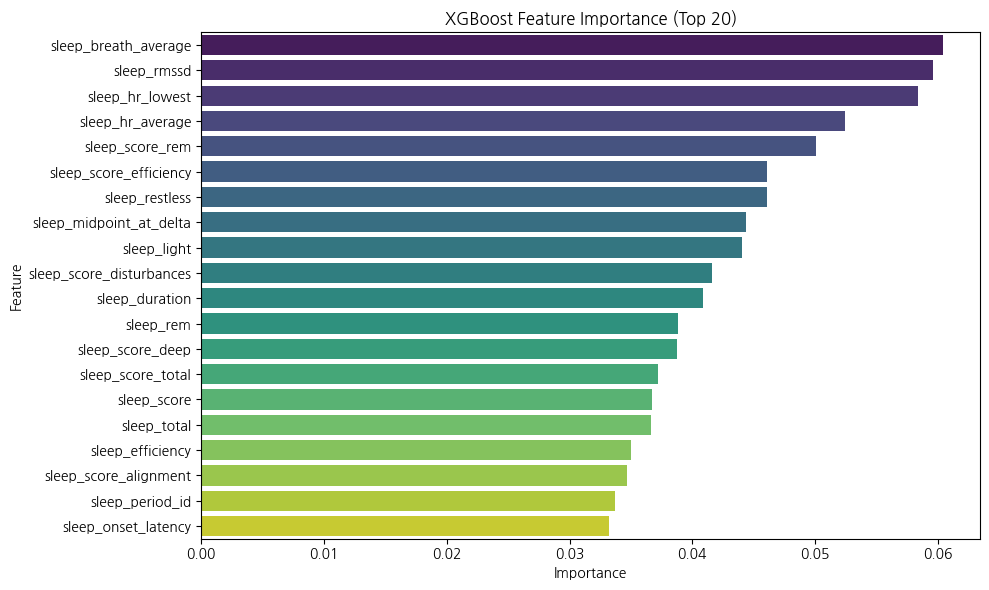

In [6]:
# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 1})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/base/train_label.csv"
train_sleep = "./data/base/train_sleep.csv"
test_label = "./data/base/validation_label.csv"
test_sleep = "./data/base/validation_sleep.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_sleep)
test_df = load_sleep_data(test_label, test_sleep)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
substrings_to_remove = ['Unnamed: 0']
numeric_cols = [col for col in numeric_cols if not any(col in sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values
y = train_df["label"].values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
X_scaled = X

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
metrics = {"fold": [], "mci_recall": [], "mci_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]

    model = XGBClassifier(random_state=42, eval_metric="logloss")
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    mci_recall = report_dict["1"]["recall"]
    mci_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["mci_recall"].append(mci_recall)
    metrics["mci_f1"].append(mci_f1)

    print(f"📌 MCI Recall: {mci_recall:.4f} | MCI F1: {mci_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (MCI only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = X_test
y_test = test_df["label"].values

final_model = XGBClassifier(random_state=42, eval_metric="logloss")
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Baseline


🔁 Fold 1
📌 MCI Recall: 0.2711 | MCI F1: 0.2921

🔁 Fold 2
📌 MCI Recall: 0.2136 | MCI F1: 0.2576

🔁 Fold 3
📌 MCI Recall: 0.2824 | MCI F1: 0.2922

📊 CV Metrics Per Fold (MCI only):
   fold  mci_recall    mci_f1
0     1    0.271123  0.292146
1     2    0.213647  0.257591
2     3    0.282449  0.292230

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.61      0.67      0.64      6024
         비정상       0.31      0.26      0.28      3533

    accuracy                           0.52      9557
   macro avg       0.46      0.46      0.46      9557
weighted avg       0.50      0.52      0.51      9557


📊 Test Set Evaluation
              precision    recall  f1-score   support

          정상       0.69      0.74      0.71      1713
         비정상       0.43      0.38      0.40       913

    accuracy                           0.61      2626
   macro avg       0.56      0.56      0.56      2626
weighted avg       0.60      0.61    

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_27528/939955414.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")


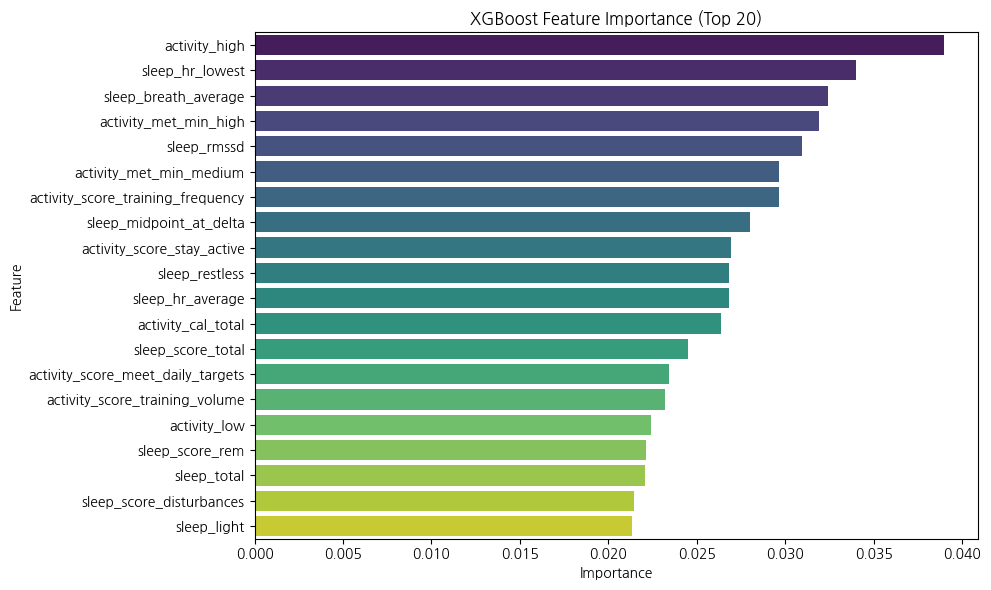

In [66]:
# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 1})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/base/train_label.csv"
train_sleep = "./data/base/train_merged.csv"
test_label = "./data/base/validation_label.csv"
test_sleep = "./data/base/validation_merged.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_sleep)
test_df = load_sleep_data(test_label, test_sleep)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
substrings_to_remove = ['Unnamed: 0']
numeric_cols = [col for col in numeric_cols if not any(col in sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values
y = train_df["label"].values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
metrics = {"fold": [], "mci_recall": [], "mci_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]

    model = XGBClassifier(random_state=42, eval_metric="logloss")
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    mci_recall = report_dict["1"]["recall"]
    mci_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["mci_recall"].append(mci_recall)
    metrics["mci_f1"].append(mci_f1)

    print(f"📌 MCI Recall: {mci_recall:.4f} | MCI F1: {mci_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (MCI only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["label"].values

final_model = XGBClassifier(random_state=42, eval_metric="logloss")
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [67]:
# -------------------------
# 10. 이메일(사람) 단위 최빈 라벨 기준 평가
# -------------------------
# 테스트셋에 예측 결과 붙이기
test_df["y_true"] = y_test
test_df["y_pred"] = y_pred_test

# 이메일별로 실제 라벨과 예측 라벨의 mode 계산
from scipy.stats import mode

person_level_preds = (
    test_df.groupby("EMAIL")[["y_true", "y_pred"]]
    .agg(lambda x: mode(x).mode[0])  # 최빈값
    .reset_index()
)

# 최종 평가
print("\n📊 [사람 단위] 최빈 예측 기반 평가")
print(classification_report(person_level_preds["y_true"], person_level_preds["y_pred"], target_names=["정상", "비정상"]))


📊 [사람 단위] 최빈 예측 기반 평가
              precision    recall  f1-score   support

          정상       0.68      0.83      0.75        23
         비정상       0.56      0.36      0.43        14

    accuracy                           0.65        37
   macro avg       0.62      0.59      0.59        37
weighted avg       0.63      0.65      0.63        37



/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_27528/1369627713.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  .agg(lambda x: mode(x).mode[0])  # 최빈값


# 전처리 후 모델


🔁 Fold 1
📌 MCI Recall: 0.3240 | MCI F1: 0.3250

🔁 Fold 2
📌 MCI Recall: 0.2673 | MCI F1: 0.3253

🔁 Fold 3
📌 MCI Recall: 0.2963 | MCI F1: 0.3075

📊 CV Metrics Per Fold (MCI only):
   fold  mci_recall    mci_f1
0     1    0.324048  0.324953
1     2    0.267262  0.325260
2     3    0.296327  0.307497

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.62      0.67      0.65      6024
         비정상       0.35      0.29      0.32      3533

    accuracy                           0.53      9557
   macro avg       0.48      0.48      0.48      9557
weighted avg       0.52      0.53      0.53      9557


📊 Test Set Evaluation
              precision    recall  f1-score   support

          정상       0.69      0.71      0.70      1713
         비정상       0.43      0.40      0.41       913

    accuracy                           0.60      2626
   macro avg       0.56      0.56      0.56      2626
weighted avg       0.60      0.60    

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_27528/1857196958.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")


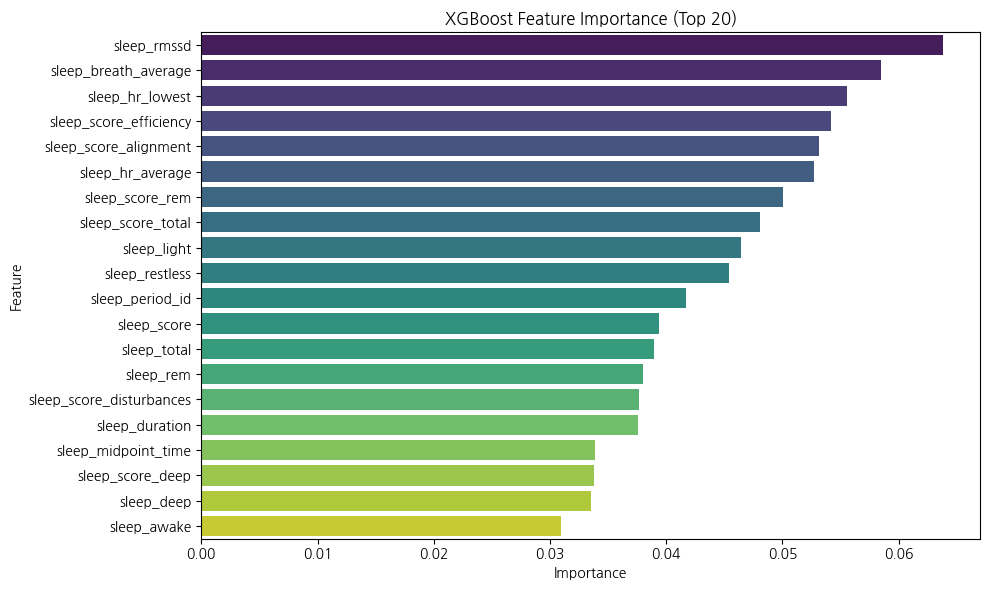

In [87]:
# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 1})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/preprocessed/train/train_label_preprocessed.csv"
train_sleep = "./data/preprocessed/train/train_sleep_preprocessed.csv"
test_label = "./data/preprocessed/validation/validation_label_preprocessed.csv"
test_sleep = "./data/preprocessed/validation/validation_sleep_preprocessed.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_sleep)
test_df = load_sleep_data(test_label, test_sleep)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
substrings_to_remove = ['sleep_midpoint_at_delta']
numeric_cols = [col for col in numeric_cols if not any(col == sub for sub in substrings_to_remove)]

X = train_df[numeric_cols].values
y = train_df["label"].values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
metrics = {"fold": [], "mci_recall": [], "mci_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]

    model = XGBClassifier(random_state=42, eval_metric="logloss")
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    mci_recall = report_dict["1"]["recall"]
    mci_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["mci_recall"].append(mci_recall)
    metrics["mci_f1"].append(mci_f1)

    print(f"📌 MCI Recall: {mci_recall:.4f} | MCI F1: {mci_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (MCI only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["label"].values

final_model = XGBClassifier(random_state=42, eval_metric="logloss")
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 최종 개선 모델


🔁 Fold 1
📌 MCI Recall: 0.2653 | MCI F1: 0.3094

🔁 Fold 2
📌 MCI Recall: 0.4327 | MCI F1: 0.4219

🔁 Fold 3
📌 MCI Recall: 0.2839 | MCI F1: 0.3366

📊 CV Metrics Per Fold (MCI only):
   fold  mci_recall    mci_f1
0     1    0.265321  0.309374
1     2    0.432715  0.421946
2     3    0.283931  0.336570

📊 CV Classification Report (Aggregated):
              precision    recall  f1-score   support

          정상       0.64      0.72      0.67      5922
         비정상       0.40      0.31      0.35      3531

    accuracy                           0.57      9453
   macro avg       0.52      0.52      0.51      9453
weighted avg       0.55      0.57      0.55      9453


📊 Test Set Evaluation
              precision    recall  f1-score   support

          정상       0.83      0.81      0.82      1712
         비정상       0.66      0.69      0.68       913

    accuracy                           0.77      2625
   macro avg       0.75      0.75      0.75      2625
weighted avg       0.77      0.77    

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_27528/102637955.py:155: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")


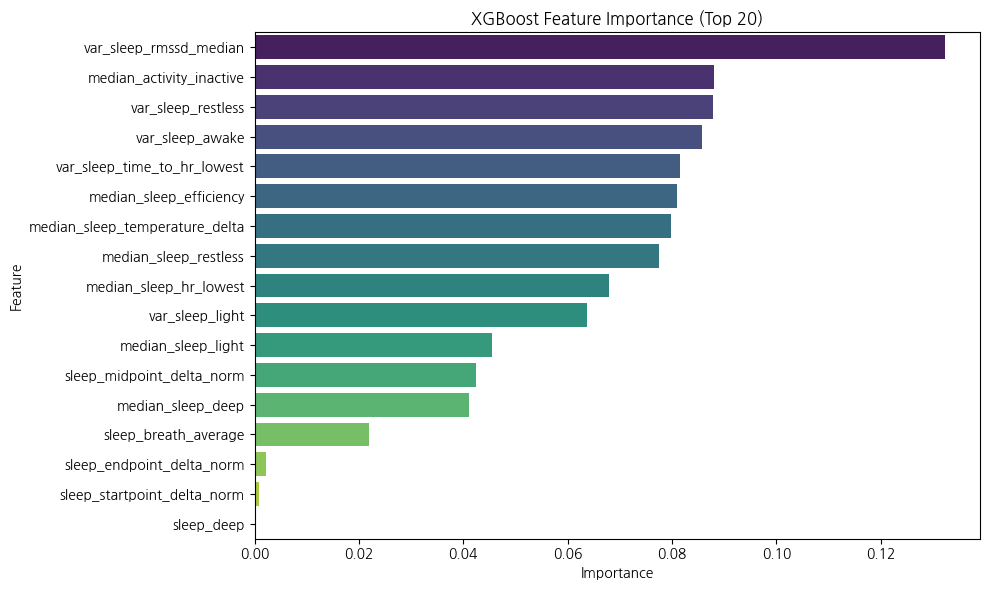

In [106]:

# -------------------------
# 1. 데이터 로딩 함수
# -------------------------
def load_sleep_data(label_path, sleep_path):
    label_df = pd.read_csv(label_path).rename(columns={"SAMPLE_EMAIL": "EMAIL"})
    sleep_df = pd.read_csv(sleep_path)
    sleep_df["sleep_bedtime_start"] = pd.to_datetime(sleep_df["sleep_bedtime_start"])
    sleep_df["sleep_bedtime_end"] = pd.to_datetime(sleep_df["sleep_bedtime_end"])

    sleep_df = pd.merge(sleep_df, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")
    sleep_df = sleep_df.sort_values(by=["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
    sleep_df["label"] = sleep_df["DIAG_NM"].map({"CN": 0, "MCI": 1, "Dem": 1})
    return sleep_df

# -------------------------
# 2. 경로 설정
# -------------------------
train_label = "./data/engineered/train/train_label_engineered.csv"
train_sleep = "./data/engineered/train/merged_engineered.csv"
test_label = "./data/engineered/validation/validation_label_engineered.csv"
test_sleep = "./data/engineered/validation/merged_engineered.csv"

# -------------------------
# 3. 데이터 로딩
# -------------------------
train_df = load_sleep_data(train_label, train_sleep)
test_df = load_sleep_data(test_label, test_sleep)

# -------------------------
# 4. 수치형 피처 추출
# -------------------------
numeric_cols = train_df.select_dtypes(include='number').drop(columns=["label"]).columns.tolist()
substrings_to_remove = [
]
numeric_cols = [col for col in numeric_cols 
                if (('activity' not in col) 
                    or (col in [
                        'median_activity_inactive'
                        ])) 
                and (col not in substrings_to_remove)]

X = train_df[numeric_cols].values
y = train_df["label"].values
groups = train_df["EMAIL"].values

# -------------------------
# 5. 스케일링
# -------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# 6. Cross-validation 설정
# -------------------------
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
metrics = {"fold": [], "mci_recall": [], "mci_f1": []}
total_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y, groups)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train_fold = X_scaled[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X_scaled[val_idx]
    y_val_fold = y[val_idx]


    model = XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        colsample_bytree=0.8,
        learning_rate=0.2,
        max_depth=7,
        n_estimators=100,
        subsample=1.0
    )
    model.fit(X_train_fold, y_train_fold)

    y_pred = model.predict(X_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred, labels=[0, 1])
    total_cm += cm

    report_dict = classification_report(y_val_fold, y_pred, output_dict=True)
    mci_recall = report_dict["1"]["recall"]
    mci_f1 = report_dict["1"]["f1-score"]

    metrics["fold"].append(fold + 1)
    metrics["mci_recall"].append(mci_recall)
    metrics["mci_f1"].append(mci_f1)

    print(f"📌 MCI Recall: {mci_recall:.4f} | MCI F1: {mci_f1:.4f}")

# -------------------------
# 7. 결과 요약
# -------------------------
metrics_df = pd.DataFrame(metrics)
print("\n📊 CV Metrics Per Fold (MCI only):")
print(metrics_df)

print("\n📊 CV Classification Report (Aggregated):")
avg_report = classification_report(
    y_true=np.repeat([0, 1], total_cm.sum(axis=1)),
    y_pred=np.concatenate([
        [0] * total_cm[0][0] + [1] * total_cm[0][1],
        [0] * total_cm[1][0] + [1] * total_cm[1][1]
    ]),
    target_names=["정상", "비정상"]
)
print(avg_report)

# -------------------------
# 8. Test Set 성능 평가
# -------------------------
X_test = test_df[numeric_cols].values
X_test_scaled = scaler.transform(X_test)
y_test = test_df["label"].values

final_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    subsample=1.0
)
final_model.fit(X_scaled, y)
y_pred_test = final_model.predict(X_test_scaled)

print("\n📊 Test Set Evaluation")
print(classification_report(y_test, y_pred_test, target_names=["정상", "비정상"]))

# -------------------------
# 9. Feature Importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\n📊 Top 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20), palette="viridis")
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [69]:
# -------------------------
# 10. 이메일(사람) 단위 최빈 라벨 기준 평가
# -------------------------
# 테스트셋에 예측 결과 붙이기
test_df["y_true"] = y_test
test_df["y_pred"] = y_pred_test

# 이메일별로 실제 라벨과 예측 라벨의 mode 계산
from scipy.stats import mode

person_level_preds = (
    test_df.groupby("EMAIL")[["y_true", "y_pred"]]
    .agg(lambda x: mode(x).mode[0])  # 최빈값
    .reset_index()
)

# 최종 평가
print("\n📊 [사람 단위] 최빈 예측 기반 평가")
print(classification_report(person_level_preds["y_true"], person_level_preds["y_pred"], target_names=["정상", "비정상"]))


📊 [사람 단위] 최빈 예측 기반 평가
              precision    recall  f1-score   support

          정상       0.82      0.78      0.80        23
         비정상       0.67      0.71      0.69        14

    accuracy                           0.76        37
   macro avg       0.74      0.75      0.74        37
weighted avg       0.76      0.76      0.76        37



/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_27528/1369627713.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  .agg(lambda x: mode(x).mode[0])  # 최빈값


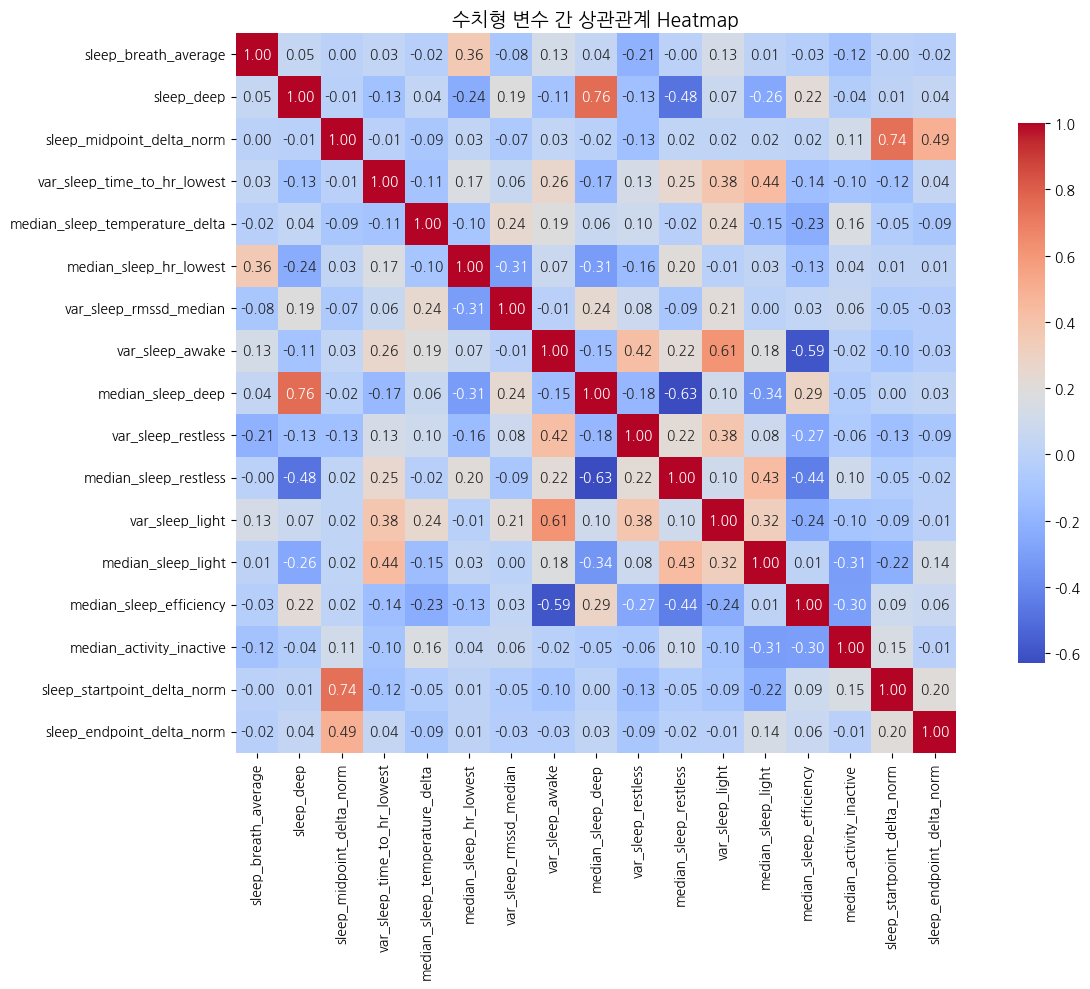

In [61]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    train_df[numeric_cols].corr(),
    annot=True,             # 🔹 어노테이션 표시
    fmt=".2f",              # 🔹 소수점 2자리 표시
    cmap="coolwarm",        # 🔹 컬러맵 설정
    square=True,            # 🔹 정사각형 셀
    cbar_kws={"shrink": 0.75}  # 🔹 컬러바 축소
)
plt.title("수치형 변수 간 상관관계 Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

# 하이퍼파라미터 튜닝

In [51]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

# -------------------------
# 1. 파라미터 후보 정의
# -------------------------
param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

# -------------------------
# 2. 파이프라인 구성
# -------------------------
pipeline = Pipeline([
    ("xgb", XGBClassifier(random_state=42, eval_metric="logloss"))
])

f1_positive_scorer = make_scorer(f1_score, pos_label=1)

# -------------------------
# 3. CV 구성 및 GridSearch
# -------------------------
group_kfold = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=f1_positive_scorer,
    cv=group_kfold.split(X_scaled, y, groups),
    verbose=1,
    n_jobs=-1
)

# -------------------------
# 4. 학습 및 최적 파라미터 확인
# -------------------------
grid_search.fit(X_scaled, y)
print("\n✅ Best Parameters:")
print(grid_search.best_params_)

print("\n🏆 Best CV F1 Score:")
print(grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits

✅ Best Parameters:
{'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}

🏆 Best CV F1 Score:
0.3559629890227862
